In [1]:
import numpy as np # linear algebra
import random
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable

In [4]:
df_main   = pd.DataFrame()
# df_aaxj   = pd.read_csv("601229.csv")
dataset = pd.read_csv("601229_price_qfq_1dims_part.csv", index_col=0)
# df_main   = df_main.join(df_aaxj)
df_main   = dataset

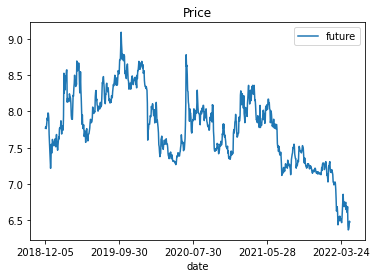

In [5]:
# df_main[['Close']].plot()
# plt.ylabel("stock_price")
df_main[['future']].plot()
plt.title("Price")
plt.show()

In [6]:
df_main

,future,close
date,,
2018-12-05,7.7706,7.8583
2018-12-06,7.7909,7.7706
2018-12-07,7.7639,7.7909
2018-12-10,7.8044,7.7639
2018-12-11,7.8651,7.8044
...,...,...
2022-04-25,6.3700,6.4300
2022-04-26,6.3800,6.3700
2022-04-27,6.4100,6.3800


In [7]:
# sel_col = ['Open', 'High', 'Low', 'Close']
# df_main = df_main[sel_col]
df_main.head()

,future,close
date,,
2018-12-05,7.7706,7.8583
2018-12-06,7.7909,7.7706
2018-12-07,7.7639,7.7909
2018-12-10,7.8044,7.7639
2018-12-11,7.8651,7.8044


In [10]:
# df_main = df_main.fillna(method='ffill')
# scaler = MinMaxScaler(feature_range=(-1, 1))
# for col in sel_col:
#     df_main[col] = scaler.fit_transform(df_main[col].values.reshape(-1,1))

In [16]:
# df_main['target'] = df_main['Close'].shift(-1) 
print(df_main)
# df_main['target'] = df_main['future']
# df_main.pop('future')
# df_main.pop('date')
df_main.dropna()
df_main = df_main.astype(np.float32)

             close  target
date                      
2018-12-05  7.8583  7.7706
2018-12-06  7.7706  7.7909
2018-12-07  7.7909  7.7639
2018-12-10  7.7639  7.8044
2018-12-11  7.8044  7.8651
...            ...     ...
2022-04-25  6.4300  6.3700
2022-04-26  6.3700  6.3800
2022-04-27  6.3800  6.4100
2022-04-28  6.4100  6.4900
2022-04-29  6.4900  6.4800

[825 rows x 2 columns]


In [17]:
df_main

,close,target
date,,
2018-12-05,7.8583,7.7706
2018-12-06,7.7706,7.7909
2018-12-07,7.7909,7.7639
2018-12-10,7.7639,7.8044
2018-12-11,7.8044,7.8651
...,...,...
2022-04-25,6.4300,6.3700
2022-04-26,6.3700,6.3800
2022-04-27,6.3800,6.4100


In [18]:
def create_seq_data(data_raw,seq):
    data_feat,data_target = [],[]
    for index in range(len(data_raw) - seq):
        # data_feat.append(data_raw[['Open', 'High', 'Low', 'Close']][index: index + seq].values)
        data_feat.append(data_raw[data_raw.columns][index: index + seq].values)
        data_target.append(data_raw['target'][index:index + seq])
    data_feat = np.array(data_feat)
    data_target = np.array(data_target)
    return data_feat,data_target

def train_test(data_feat,data_target,test_set_size,seq):
    train_size = data_feat.shape[0] - (test_set_size) 
    trainX = torch.from_numpy(data_feat[:train_size].reshape(-1,seq,data_feat.shape[2])).type(torch.Tensor)
    testX  = torch.from_numpy(data_feat[train_size:].reshape(-1,seq,data_feat.shape[2])).type(torch.Tensor)
    trainY = torch.from_numpy(data_target[:train_size].reshape(-1,seq,1)).type(torch.Tensor)
    testY  = torch.from_numpy(data_target[train_size:].reshape(-1,seq,1)).type(torch.Tensor)
    return trainX,trainY,testX,testY

In [19]:
data_raw = df_main
seq = 20
test_set_size = int(np.round(0.2*data_raw.shape[0]))
# generate train & test dataset
feat,target = create_seq_data(data_raw,seq)
trainX,trainY,testX,testY = train_test(feat,target,test_set_size,seq)

In [20]:
print('x_train.shape = ',trainX.shape)
print('y_train.shape = ',trainY.shape)
print('x_test.shape = ',testX.shape)
print('y_test.shape = ',testY.shape)

x_train.shape =  torch.Size([640, 20, 2])
y_train.shape =  torch.Size([640, 20, 1])
x_test.shape =  torch.Size([165, 20, 2])
y_test.shape =  torch.Size([165, 20, 1])


In [21]:
n_steps = seq
batch_size = 1442
num_epochs = 100

In [22]:
train = torch.utils.data.TensorDataset(trainX,trainY)
test = torch.utils.data.TensorDataset(testX,testY)
train_loader = torch.utils.data.DataLoader(dataset=train, 
                                           batch_size=batch_size, 
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [23]:
# Build model
#####################
# input_dim = 4
input_dim = trainX.shape[2]
hidden_dim = 32
num_layers = 2 
output_dim = 1
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # One time step
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        out = self.fc(out) 
        # out.size() --> 100, 10
        return out
    

In [24]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss(size_average=True)

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(2, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 2])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


E:\python37\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [25]:
# train model
hist = np.zeros(num_epochs)
seq_dim = seq
for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
    y_train_pred = model(trainX)

    loss = loss_fn(y_train_pred, trainY)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  11.84472370147705
Epoch  20 MSE:  0.5639323592185974
Epoch  30 MSE:  1.4410263299942017
Epoch  40 MSE:  0.46271634101867676
Epoch  50 MSE:  0.4560987055301666
Epoch  60 MSE:  0.371542364358902
Epoch  70 MSE:  0.35885390639305115
Epoch  80 MSE:  0.3454025387763977
Epoch  90 MSE:  0.34293049573898315


In [26]:
p = y_train_pred.detach().numpy()[:,-1,0]
trainY_target = trainY.detach().numpy()[:,-1,0]

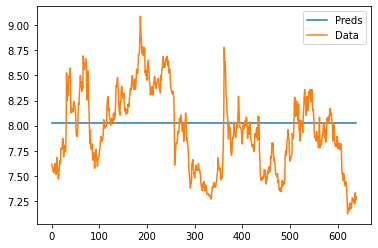

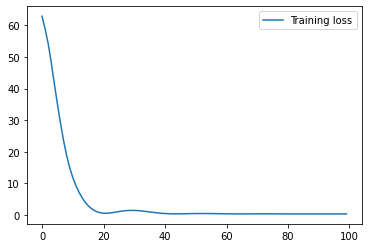

In [27]:
plt.plot(p, label="Preds")
plt.plot(trainY_target, label="Data")
plt.legend()
plt.show()

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [ ]:
# make predictions
y_test_pred = model(testX)
y_train_pred.detach().numpy()[:,-1,0]

In [ ]:
# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy()[:,-1,0].reshape(-1,1))
y_train = scaler.inverse_transform(trainY.detach().numpy()[:,-1,0].reshape(-1,1))
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy()[:,-1,0].reshape(-1,1))
y_test = scaler.inverse_transform(testY.detach().numpy()[:,-1,0].reshape(-1,1))

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train, y_train_pred))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test, y_test_pred))
print('Test Score: %.2f RMSE' % (testScore))

In [ ]:
df_test_final = pd.DataFrame(y_test,columns = ['y_test']).join(pd.DataFrame(y_test_pred,columns = ['y_test_pred']))

In [ ]:
df_test_final[['y_test', 'y_test_pred']].plot()
plt.ylabel("ETFs_price")
plt.show()